# Tutorial 2: Breaking Linearity – Intro to PyTorch & GPUs

**Course:** CSEN 342: Deep Learning  
**Topic:** PyTorch Basics, Multi-Layer Perceptrons, and GPU Acceleration

## Objective
In the previous tutorial, we manually implemented a neural network using NumPy to solve the XOR problem. In this tutorial, we will upgrade our workflow to use **PyTorch**, the industry-standard framework for Deep Learning.

We will:
1.  Re-implement the XOR classifier using PyTorch's `nn.Module` and autograd system.
2.  Learn how to manage compute resources (CPU vs. GPU).
3.  **Benchmark** a large matrix multiplication to scientifically demonstrate the speed advantage of using High Performance Computing (HPC) GPUs over standard CPUs.

---

## Part 1: Solving XOR with PyTorch

PyTorch handles the heavy lifting of backpropagation for us. Instead of manually calculating derivatives and chain rules (as we did in NumPy), we define the "Forward Pass" and let PyTorch calculate the gradients automatically.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# 1. Define Data (XOR Problem)
# Note: We must convert data to PyTorch Tensors (Float32)
X = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

print(f"Input Shape: {X.shape}")
print(f"Target Shape: {y.shape}")

Input Shape: torch.Size([4, 2])
Target Shape: torch.Size([4, 1])


### 1.1 Define the Model Architecture
We will create a class that inherits from `nn.Module`. We need:
* **Hidden Layer:** Linear transformation from 2 inputs -> 4 neurons.
* **Activation:** ReLU or Sigmoid (to break linearity).
* **Output Layer:** Linear transformation from 4 neurons -> 1 output.

In [2]:
class XORModel(nn.Module):
    def __init__(self):
        super(XORModel, self).__init__()
        # Layer 1: 2 input features -> 4 hidden neurons
        self.layer1 = nn.Linear(2, 4)
        # Layer 2: 4 hidden neurons -> 1 output neuron
        self.layer2 = nn.Linear(4, 1)
        # Activations
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Pass input through layer 1, then activation
        x = self.sigmoid(self.layer1(x))
        # Pass result through layer 2, then activation (for probability)
        x = self.sigmoid(self.layer2(x))
        return x

# Instantiate the model
model = XORModel()
print(model)

XORModel(
  (layer1): Linear(in_features=2, out_features=4, bias=True)
  (layer2): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


### 1.2 Training Loop
Instead of manually updating `W -= lr * gradient`, we use an **Optimizer** (`SGD` or `Adam`) and a **Loss Function** (`BCELoss` for binary classification).

Starting Training...
Epoch 0 | Loss: 0.7280
Epoch 1000 | Loss: 0.6880
Epoch 2000 | Loss: 0.6406
Epoch 3000 | Loss: 0.4889
Epoch 4000 | Loss: 0.2519
Training Complete.


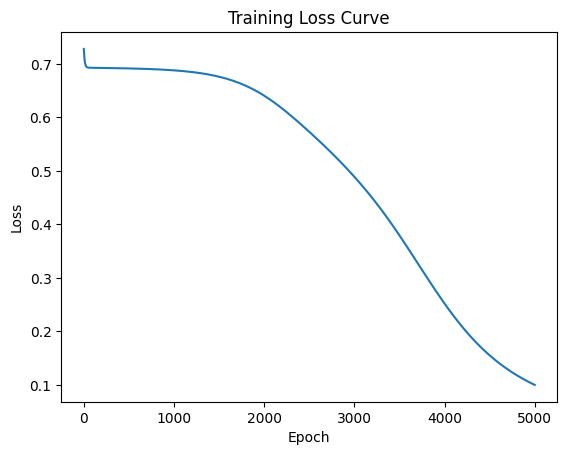

In [3]:
# Hyperparameters
learning_rate = 0.1
epochs = 5000

# Loss and Optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

losses = []

print("Starting Training...")
for epoch in range(epochs):
    # 1. Forward Pass
    predictions = model(X)
    loss = criterion(predictions, y)
    
    # 2. Backward Pass (Autograd)
    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()        # Calculate new gradients
    optimizer.step()       # Update weights
    
    losses.append(loss.item())
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

print("Training Complete.")

# Visualize Loss
plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### 1.3 Verify Results
Did PyTorch succeed where the linear Perceptron failed? Let's verify predictions.

In [4]:
with torch.no_grad():
    # Round output to get 0 or 1 class predictions
    preds = model(X).round()
    print("True Labels:\n", y.numpy().flatten())
    print("Model Preds:\n", preds.numpy().flatten())
    
    accuracy = (preds.eq(y).sum() / float(y.shape[0])).item()
    print(f"Accuracy: {accuracy * 100}%")

True Labels:
 [0. 1. 1. 0.]
Model Preds:
 [0. 1. 1. 0.]
Accuracy: 100.0%


---

## Part 2: GPU Basics & Benchmarking

The XOR problem is tiny; a CPU solves it instantly. However, deep learning involves matrix multiplications of millions of parameters. This is where GPUs (Graphics Processing Units) shine because they are designed for massive parallelism.

### 2.1 Device Management
In PyTorch, you must explicitly move your data and your model to the GPU.

In [5]:
# Check if CUDA (NVIDIA GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU Detected: {torch.cuda.get_device_name(0)}")
    print(f"Device Count: {torch.cuda.device_count()}")
else:
    device = torch.device("cpu")
    print("No GPU detected. Running on CPU.")

GPU Detected: Tesla V100-PCIE-32GB
Device Count: 1


### 2.2 Benchmarking: CPU vs. GPU

We will create two massive matrices (size 10,000 x 10,000) and multiply them. We will time how long this takes on the CPU versus the GPU.

*Note: The first time you run a CUDA operation, there is a slight initialization overhead.*

In [6]:
import time

# Matrix Size: 10,000 x 10,000
SIZE = 10000

print(f"Creating random matrices of size {SIZE}x{SIZE}...")
a_cpu = torch.randn(SIZE, SIZE)
b_cpu = torch.randn(SIZE, SIZE)

# --- CPU Benchmark ---
print("Starting CPU Matrix Multiplication... (This might take a while)")
start_time = time.time()

# Perform matrix multiplication on CPU
c_cpu = torch.matmul(a_cpu, b_cpu)

end_time = time.time()
cpu_time = end_time - start_time
print(f"CPU Time: {cpu_time:.4f} seconds")

print("-" * 30)

Creating random matrices of size 10000x10000...
Starting CPU Matrix Multiplication... (This might take a while)
CPU Time: 9.8829 seconds
------------------------------


In [7]:
# --- GPU Benchmark ---
if torch.cuda.is_available():
    print("Moving tensors to GPU...")
    # Move data to GPU
    a_gpu = a_cpu.to(device)
    b_gpu = b_cpu.to(device)
    
    # Warm-up (GPUs sometimes need a dummy op to initialize context)
    _ = torch.matmul(a_gpu[:100, :100], b_gpu[:100, :100])
    torch.cuda.synchronize() # Wait for warm-up to finish
    
    print("Starting GPU Matrix Multiplication...")
    start_time = time.time()
    
    # Perform matrix multiplication on GPU
    c_gpu = torch.matmul(a_gpu, b_gpu)
    
    # Important: CUDA operations are asynchronous.
    # We must synchronize to ensure the calculation is actually done before stopping the timer.
    torch.cuda.synchronize()
    
    end_time = time.time()
    gpu_time = end_time - start_time
    print(f"GPU Time: {gpu_time:.4f} seconds")
    
    # Calculate Speedup
    speedup = cpu_time / gpu_time
    print(f"\nSpeedup Factor: {speedup:.2f}x faster on GPU")
else:
    print("Skipping GPU test (No device found).")

Moving tensors to GPU...
Starting GPU Matrix Multiplication...
GPU Time: 0.1514 seconds

Speedup Factor: 65.28x faster on GPU


### Discussion Questions
1.  **Speedup:** Look at the speedup factor. Why is the GPU so much faster for this specific operation?
2.  **Overhead:** If we performed this multiplication on very small matrices (e.g., 5x5), do you think the GPU would still be faster? Why or why not? (Hint: Consider the time it takes to move data from RAM to GPU memory).
3.  **Workflow:** In the code above, we moved data using `.to(device)`. If you forget this step and try to multiply a CPU tensor with a GPU tensor, what happens?